# Part 5: Change Point Detection Analysis

In [1]:
# Add directory above current directory to path
import sys; 
if not ".." in sys.path:
    sys.path.insert(0, '..')
    
import time 
    
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy import stats

import ruptures as rpt

sns.set(style="darkgrid")

from utils.data_utils import *
from utils.plot_utils import tsplot_periodogram, tsplot_cpd
from utils.time_utils import *
from regularity_analysis.feature_extraction import fourier_spectrum_entropy, multiscale_entropy

%load_ext autoreload
%autoreload 2

#run this for fullscreen jupyter cells
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def prepare_result(customer_data, result_data):
    """
    Concatenate customer base frame with entropy result frame for quick Seaborn plot building
    """
    
    dfs = [customer_data, result_data]
    
    return pd.concat(dfs, axis=1)

In [3]:
#set up data and result paths
customer_base_path = "../DATA_GYM/sanitized_customer_base.csv"
login_data_path = "../DATA_GYM/sanitized_login_data.csv"
result_folder = "../results/cp_detection/statistics/2020-06-05/"

In [4]:
login_data = load_login_data(login_data_path)
customer_data = load_customer_data(customer_base_path)
customer_data

,ISACTIVE,EXPIRE_DATE,LAST_VISIT,CLASS_CODE,DATE_SAVED,DATE_LAST_MODIFIED,RENEW_DATE,PAUSE_START,PAUSE_END,BUSINESS_CODE,SEX,NO_MAIL,NO_SMS,MEMBER_SINCE,COMPANY_CUST_CODE,IS_DROP_IN_CUSTOMER,CONTRACT_DURATION,ACTIVE_DURATION,NUM_VISITS
CUST_CODE,,,,,,,,,,,,,,,,,,,
5152.10,False,2013-05-03,2013-04-16,10.10,2013-04-16 10:03:07,2013-09-26 16:14:18,1899-12-30,1899-12-30,1899-12-30,10.10,F,False,False,2013-02-04 00:00:00,NaN,False,88 days 00:00:00.000000000,71 days 00:00:00.000000000,1
4766.10,False,2013-05-19,2013-04-16,10.10,2013-04-16 10:03:17,2014-06-11 12:02:14,1899-12-30,1899-12-30,1899-12-30,10.10,F,False,False,2012-11-20 00:00:00,NaN,False,180 days 00:00:00.000000000,147 days 00:00:00.000000000,1
4674.10,False,2013-09-30,2013-04-16,10.10,2013-04-16 10:03:19,2014-06-11 12:02:15,1899-12-30,1899-12-30,1899-12-30,10.10,F,False,False,2012-11-01 00:00:00,NaN,False,333 days 00:00:00.000000000,166 days 00:00:00.000000000,1
9000130.90,False,2013-07-25,2013-04-16,10.90,2013-04-16 11:24:11,2013-09-26 16:18:43,1899-12-30,1899-12-30,1899-12-30,10.90,NaN,False,False,2012-09-18 00:00:00,NaN,False,310 days 00:00:00.000000000,210 days 00:00:00.000000000,1
2002108.30,False,2013-04-21,2013-04-16,10.30,2013-04-16 11:55:51,2014-09-22 15:02:53,1899-12-30,1899-12-30,1899-12-30,10.30,F,False,False,2012-11-21 00:00:00,NaN,False,151 days 00:00:00.000000000,146 days 00:00:00.000000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007862.40,True,2100-12-31,NaT,10.40,2018-08-09 15:39:32,2018-09-10 09:25:45,NaT,NaT,NaT,10.40,F,False,False,2018-08-09 00:00:00,NaN,False,35 days 07:57:31.000000000,0 days 00:00:00.000000000,1
9005399.90,True,2018-10-08,NaT,10.90,2018-08-09 16:50:40,2018-09-10 09:25:33,NaT,NaT,NaT,10.90,M,False,False,2018-08-09 00:00:00,NaN,False,35 days 07:57:31.000000000,0 days 00:00:00.000000000,1
2355391.33,True,2100-12-31,NaT,10.33,2018-08-10 11:17:16,2018-09-10 09:25:55,NaT,NaT,NaT,10.33,F,False,False,2018-08-10 00:00:00,NaN,False,34 days 07:57:31.000000000,0 days 00:00:00.000000000,1


In [5]:
#convert the timedelta columns to floats
customer_data["CONTRACT_DURATION"] = customer_data.apply(lambda x: x.CONTRACT_DURATION / pd.Timedelta(days=1), axis=1)
customer_data["ACTIVE_DURATION"] = customer_data.apply(lambda x: x.ACTIVE_DURATION / pd.Timedelta(days=1), axis=1)
customer_data["VISITS_PER_DAY"] = customer_data.apply(lambda x: x.NUM_VISITS / x.CONTRACT_DURATION, axis=1)

In [13]:
name = "changepoint_features"
stats_name = "changepoint_results"
stat_folder = "../results/cp_detection/statistics/2020-04-21/"
model = "l2"
file_ext = ".csv"
changepoint_stats = load_result_data(stat_folder + stats_name + "_" + model + file_ext) 
changepoint_features = load_result_data(result_folder + name + "_" + model + file_ext)

In [52]:
changepoint_stats.describe(percentiles=np.arange(1,10) * 0.1)

,PELT_aic,BinSeg_aic,Hausdorff_aic,Hamming_aic,RandIndex_aic,PELT_bic,BinSeg_bic,Hausdorff_bic,Hamming_bic,RandIndex_bic,PELT_hqc,BinSeg_hqc,Hausdorff_hqc,Hamming_hqc,RandIndex_hqc
count,138563.000000,138563.000000,137844.000000,138563.000000,138563.000000,138563.000000,138563.000000,123258.000000,138563.000000,138563.000000,138563.000000,138563.000000,130971.000000,138563.000000,138563.000000
mean,24.208122,18.405238,52.955914,0.066375,0.933625,5.614313,4.000873,94.909377,0.108886,0.891114,9.190578,6.289442,93.006582,0.114781,0.885219
std,24.419861,18.089217,95.936775,0.115682,0.115682,4.310635,2.922051,185.370114,0.179515,0.179515,7.720704,5.175430,161.848563,0.173019,0.173019
min,1.000000,1.000000,0.000000,0.000000,0.053539,1.000000,1.000000,0.000000,0.000000,0.087430,1.000000,1.000000,0.000000,0.000000,0.064724
10%,4.000000,3.000000,0.000000,0.000000,0.789284,2.000000,1.000000,0.000000,0.000000,0.592671,2.000000,2.000000,0.000000,0.000000,0.615733
20%,6.000000,5.000000,0.000000,0.000000,0.895678,2.000000,2.000000,0.000000,0.000000,0.784396,3.000000,2.000000,0.000000,0.000000,0.781804
30%,8.000000,7.000000,0.000000,0.000000,0.943805,3.000000,2.000000,0.000000,0.000000,0.904636,4.000000,3.000000,0.000000,0.000000,0.879195
40%,11.000000,9.000000,15.000000,0.005409,0.969622,3.000000,3.000000,0.000000,0.000000,0.965781,5.000000,4.000000,15.000000,0.006265,0.937550
50%,15.000000,12.000000,25.000000,0.015247,0.984753,4.000000,3.000000,15.000000,0.005618,0.994382,7.000000,5.000000,30.000000,0.027283,0.972717
60%,21.000000,16.000000,35.000000,0.030378,0.994591,5.000000,4.000000,35.000000,0.034219,1.000000,8.000000,6.000000,55.000000,0.062450,0.993735


In [149]:
changepoint_features.describe(percentiles=np.arange(1,10) * 0.1)

,PELT_bic,start_of_year_cps,cps_jan,cps_feb,cps_mar,cps_apr,cps_may,cps_jun,cps_jul,cps_aug,cps_sep,cps_oct,cps_nov,cps_dec,cp_dt_mean,cp_dt_median,cp_dt_min,cp_dt_max
count,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000,138519.000000
mean,7.471567,0.129419,0.779092,0.675301,0.697818,0.645327,0.570557,0.513092,0.457692,0.596554,0.992932,0.537753,0.530295,0.475155,104.474574,65.755644,26.298934,343.013060
std,5.127725,0.357797,1.113527,1.006717,1.040715,0.988719,0.911044,0.879900,0.860922,0.948958,1.044789,0.923347,0.913341,0.827566,99.571525,98.643485,74.150411,325.144658
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,5.000000,5.000000,9.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000,16.500000,6.000000,122.000000
50%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,79.235294,35.000000,7.000000,232.000000
75%,10.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,120.500000,76.000000,16.000000,458.000000
max,70.000000,4.000000,10.000000,11.000000,11.000000,9.000000,10.000000,9.000000,13.000000,10.000000,11.000000,9.000000,10.000000,9.000000,1976.000000,1976.000000,1976.000000,4229.000000


In [16]:
cp_result = prepare_result(customer_data, changepoint_stats)

In [94]:
cp_result.corr()

,ISACTIVE,CONTRACT_DURATION,ACTIVE_DURATION,NUM_VISITS,VISITS_PER_DAY,PELT_aic,BinSeg_aic,Hausdorff_aic,Hamming_aic,RandIndex_aic,PELT_bic,BinSeg_bic,Hausdorff_bic,Hamming_bic,RandIndex_bic,PELT_hqc,BinSeg_hqc,Hausdorff_hqc,Hamming_hqc,RandIndex_hqc
ISACTIVE,1.000000,0.378390,0.264010,0.236973,0.031790,0.290988,0.287845,0.122915,-0.051695,0.051695,0.235320,0.214041,0.164048,0.002092,-0.002092,0.270536,0.246812,0.166451,-0.010439,0.010439
CONTRACT_DURATION,0.378390,1.000000,0.869054,0.527056,-0.096648,0.768478,0.775174,0.358758,-0.127471,0.127471,0.735756,0.649560,0.472024,0.078395,-0.078395,0.799441,0.734176,0.457472,-0.009371,0.009371
ACTIVE_DURATION,0.264010,0.869054,1.000000,0.646870,0.092887,0.860541,0.843167,0.413811,-0.055647,0.055647,0.638911,0.535729,0.519225,0.132389,-0.132389,0.768673,0.666029,0.518665,0.067076,-0.067076
NUM_VISITS,0.236973,0.527056,0.646870,1.000000,0.542762,0.720252,0.701151,0.184401,-0.080189,0.080189,0.273670,0.261970,0.263107,0.026357,-0.026357,0.444707,0.378078,0.288288,0.011145,-0.011145
VISITS_PER_DAY,0.031790,-0.096648,0.092887,0.542762,1.000000,0.169918,0.157711,-0.029141,0.027623,-0.027623,-0.174705,-0.133494,-0.026440,-0.075853,0.075853,-0.063568,-0.074288,-0.002265,-0.018495,0.018495
PELT_aic,0.290988,0.768478,0.860541,0.720252,0.169918,1.000000,0.951823,0.332864,-0.076124,0.076124,0.561107,0.470823,0.455057,0.105090,-0.105090,0.768262,0.645903,0.450247,0.052543,-0.052543
BinSeg_aic,0.287845,0.775174,0.843167,0.701151,0.157711,0.951823,1.000000,0.238435,-0.177921,0.177921,0.635046,0.540357,0.447066,0.101222,-0.101222,0.832511,0.717844,0.416213,0.029485,-0.029485
Hausdorff_aic,0.122915,0.358758,0.413811,0.184401,-0.029141,0.332864,0.238435,1.000000,0.507851,-0.507851,0.265458,0.197188,0.312013,0.119052,-0.119052,0.302700,0.229110,0.462018,0.174307,-0.174307
Hamming_aic,-0.051695,-0.127471,-0.055647,-0.080189,0.027623,-0.076124,-0.177921,0.507851,1.000000,-1.000000,-0.134118,-0.143827,0.011243,0.017971,-0.017971,-0.131877,-0.156977,0.098795,0.150718,-0.150718
RandIndex_aic,0.051695,0.127471,0.055647,0.080189,-0.027623,0.076124,0.177921,-0.507851,-1.000000,1.000000,0.134118,0.143827,-0.011243,-0.017971,0.017971,0.131877,0.156977,-0.098795,-0.150718,0.150718


In [17]:
cd_normalizer = colors.LogNorm(vmin=cp_result["CONTRACT_DURATION"].min(), vmax=cp_result["CONTRACT_DURATION"].max())
nv_normalizer = colors.LogNorm(vmin=cp_result["NUM_VISITS"].min(), vmax=cp_result["NUM_VISITS"].max())
vpd_normalizer = colors.LogNorm(vmin=cp_result["VISITS_PER_DAY"].min(), vmax=cp_result["VISITS_PER_DAY"].max())

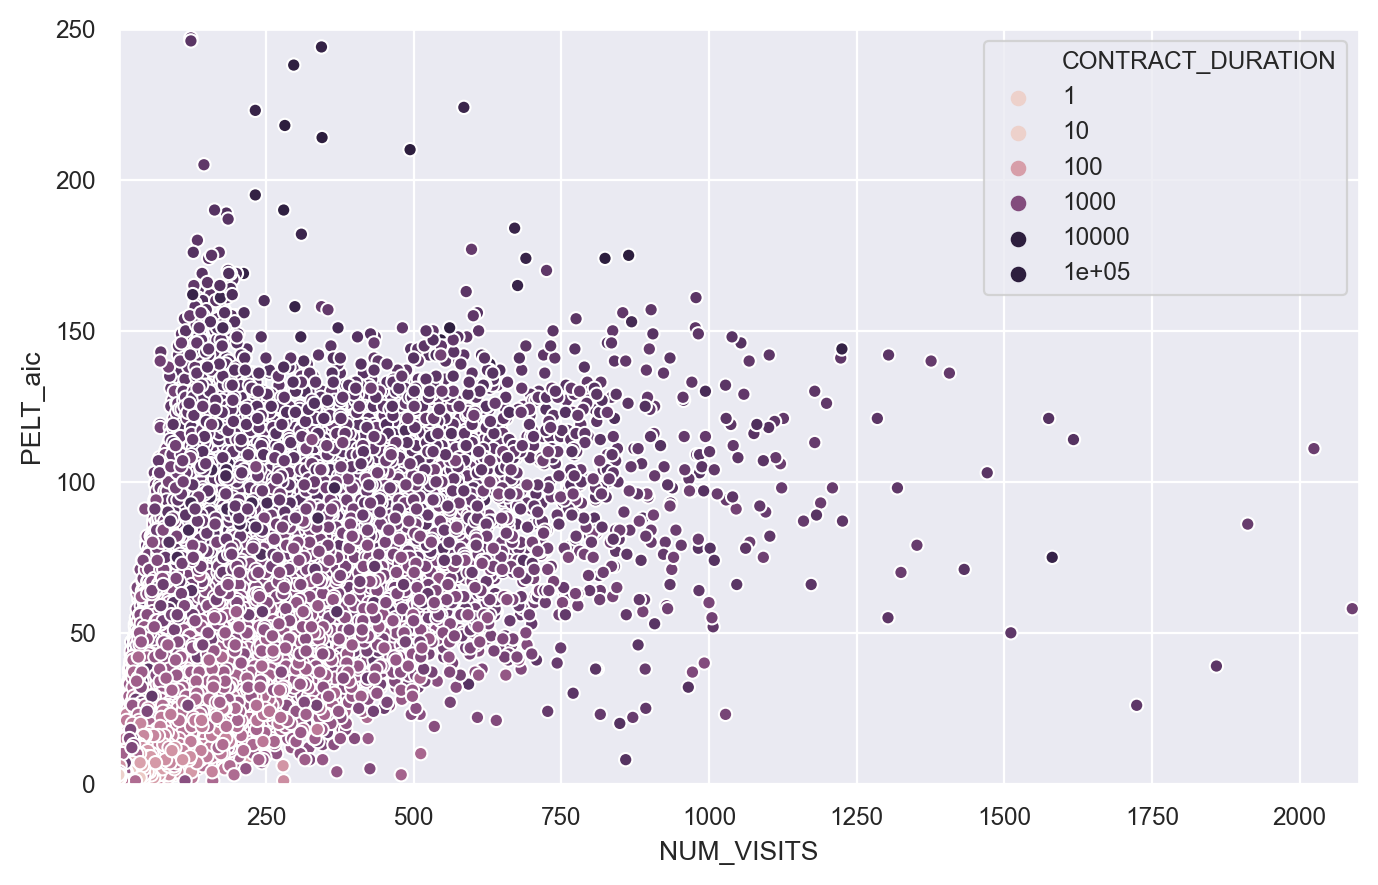

In [140]:
with sns.plotting_context("paper"):
    # Initialize figure and ax
    # Set up the matplotlib figure
    fig1, ax1 = plt.subplots(figsize=(8,5), dpi=200)

    # Set the scale of the x-and y-axes
    ax1.set(xlim=(0.9, 2100), ylim=(0,250))
    sns.scatterplot(x="NUM_VISITS", y="PELT_aic", hue="CONTRACT_DURATION", hue_norm=cd_normalizer, data=cp_result, ax=ax1, rasterized=True)

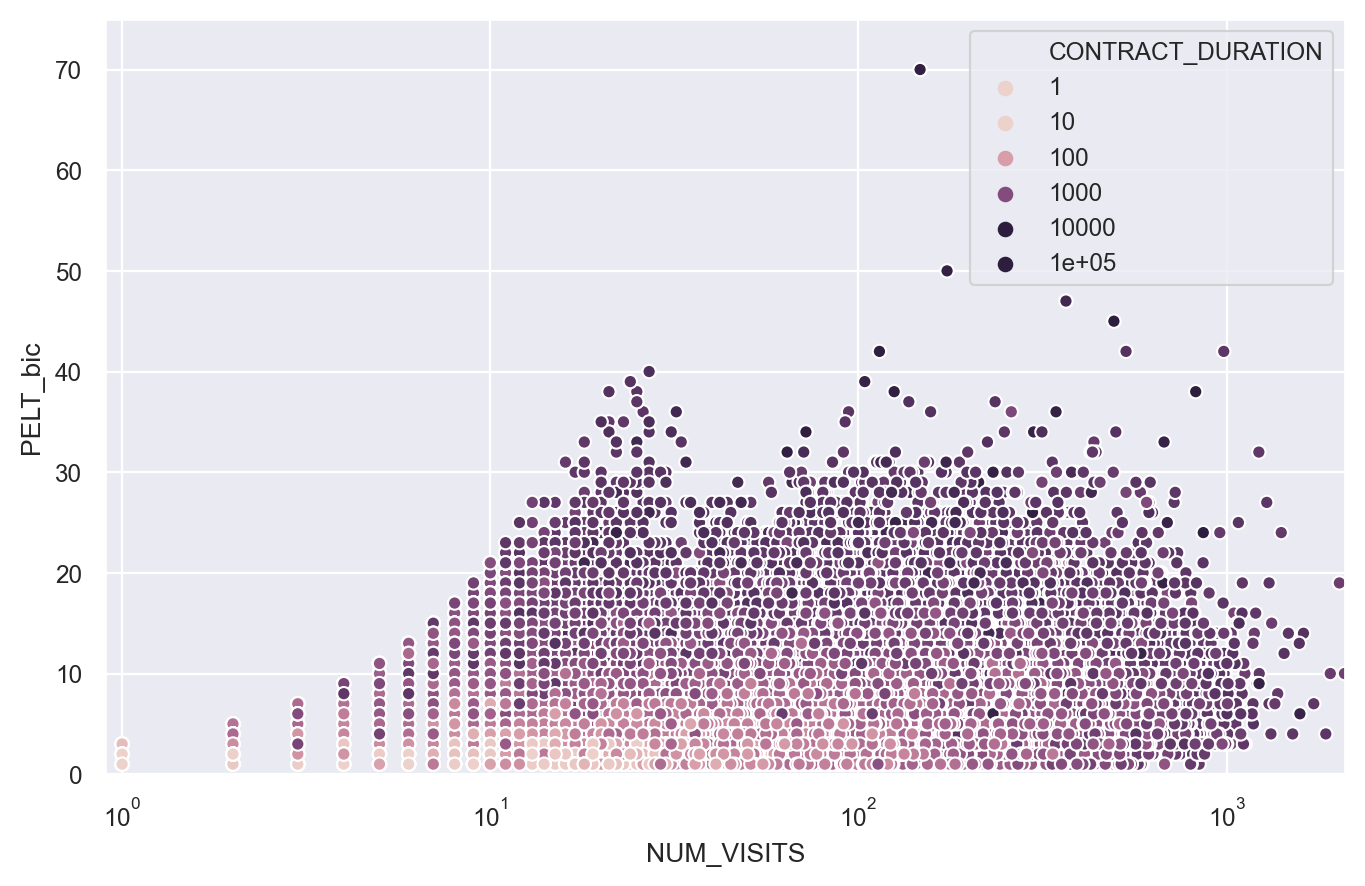

In [141]:
with sns.plotting_context("paper"):
    # Initialize figure and ax
    # Set up the matplotlib figure
    fig2, ax2 = plt.subplots(figsize=(8,5), dpi=200)

    # Set the scale of the x-and y-axes
    ax2.set(xlim=(0.9, 2100), ylim=(0,75), xscale="log")
    sns.scatterplot(x="NUM_VISITS", y="PELT_bic", hue="CONTRACT_DURATION", hue_norm=cd_normalizer, data=cp_result, ax=ax2, rasterized=True)

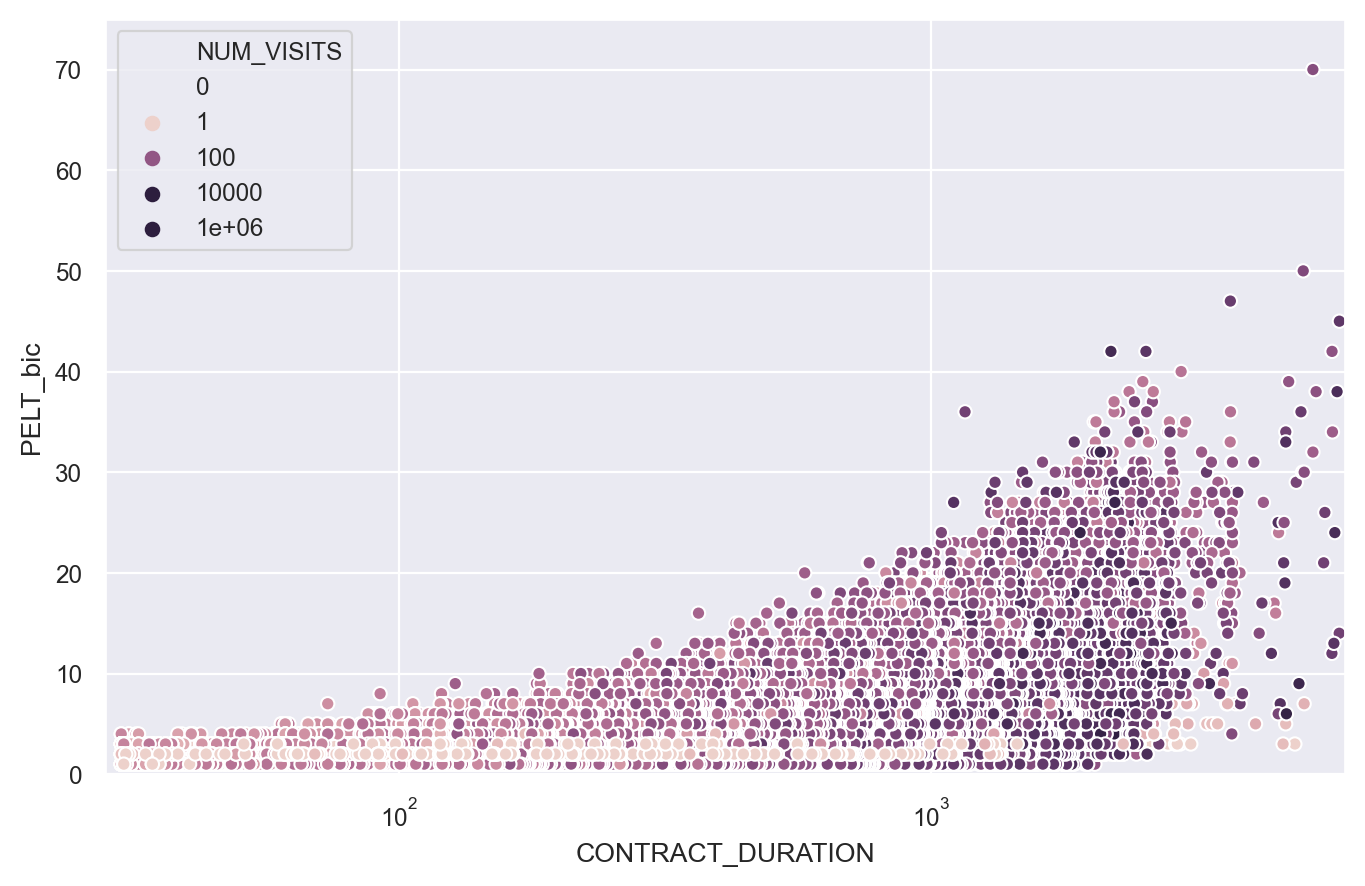

In [142]:
with sns.plotting_context("paper"):
    # Initialize figure and ax
    # Set up the matplotlib figure
    fig3, ax3 = plt.subplots(figsize=(8,5), dpi=200)

    # Set the scale of the x-and y-axes
    ax3.set(xlim=(28, 6000), ylim=(0,75), xscale="log")
    sns.scatterplot(x="CONTRACT_DURATION", y="PELT_bic", hue="NUM_VISITS", hue_norm=nv_normalizer, data=cp_result, ax=ax3, rasterized=True)

In [143]:
fig1.savefig("../plots/result_plots/cp_aic_nv.pdf", format='pdf', bbox_inches="tight")
fig2.savefig("../plots/result_plots/cp_bic_nv.pdf", format='pdf', bbox_inches="tight")
fig3.savefig("../plots/result_plots/cp_bic_cd.pdf", format='pdf', bbox_inches="tight")

In [105]:
stat_name = "Hausdorff_bic"
n = 10000
sample = cp_result.nlargest(n, stat_name).sample(1)
sample_code = sample.index[0]
print(sample[stat_name])
print(sample_code)

10777.10    470.0
Name: Hausdorff_bic, dtype: float64
10777.10


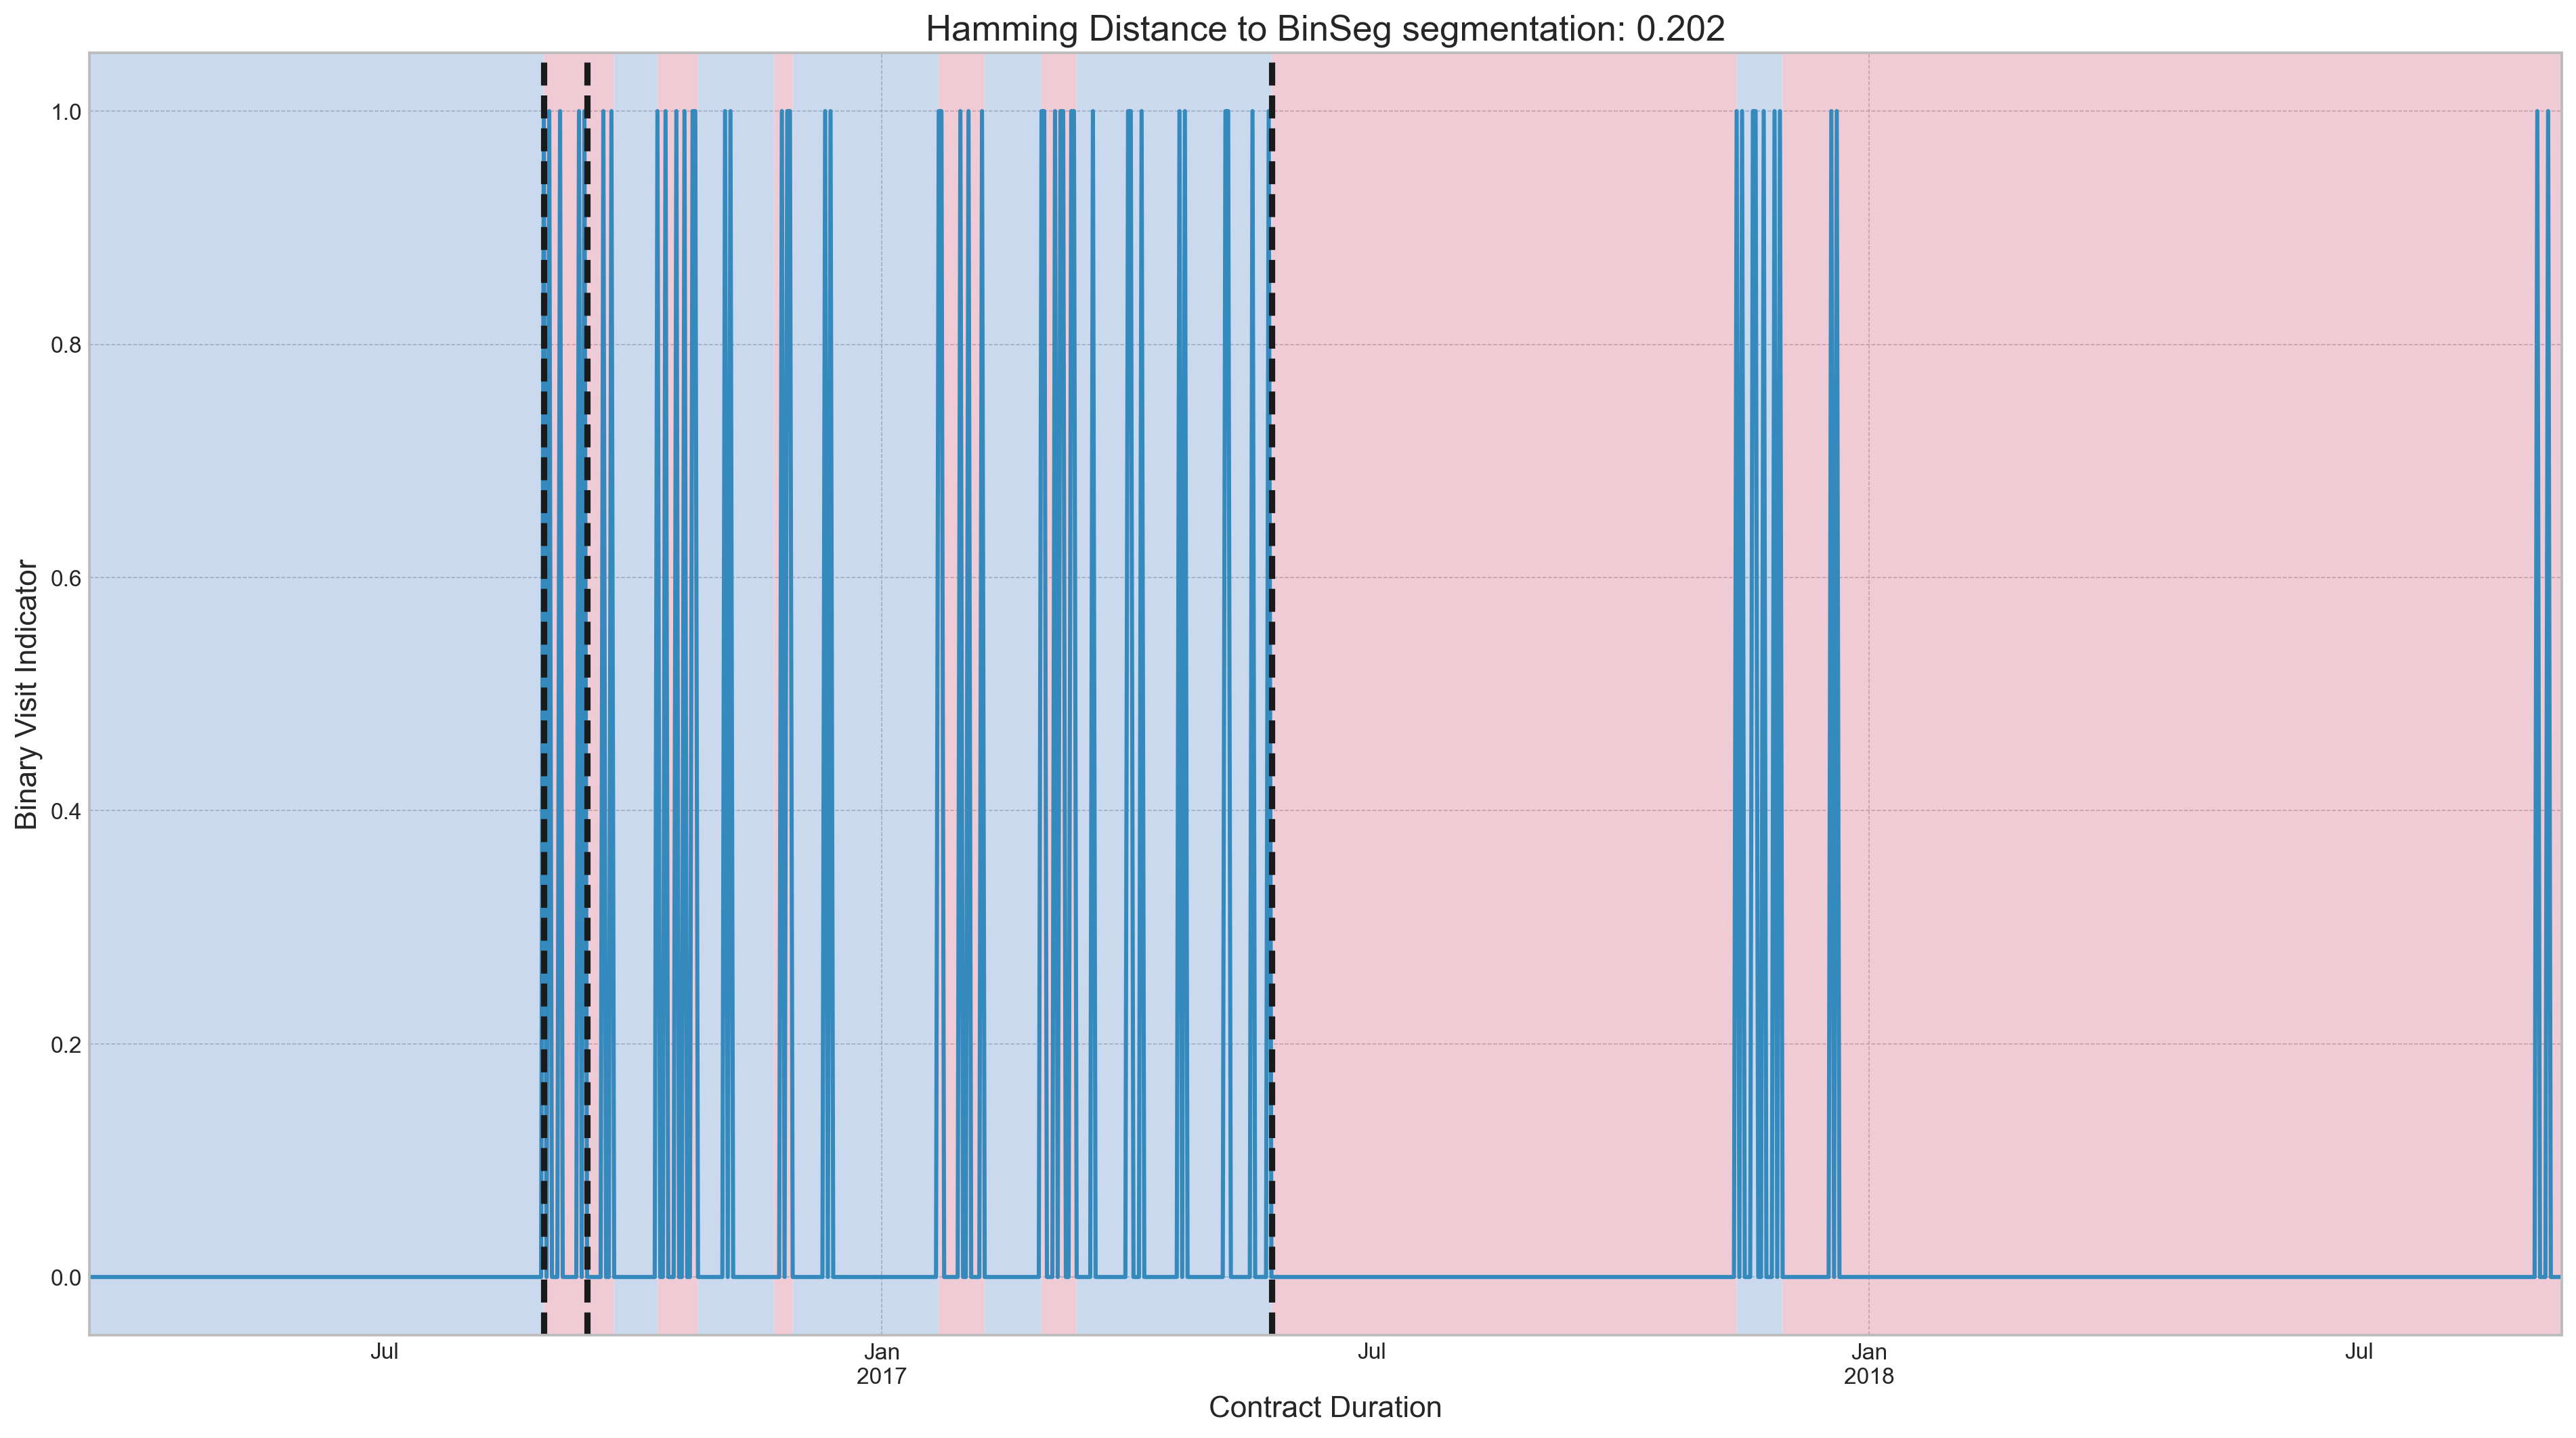

In [108]:
tsplot_cpd(sample_code, cp_result, login_data, model="l2", jump=1, min_size=7,  ic="bic")
plt.savefig("../plots/result_plots/cp_ex.pdf", format='pdf', bbox_inches="tight")

2.1091020107269287


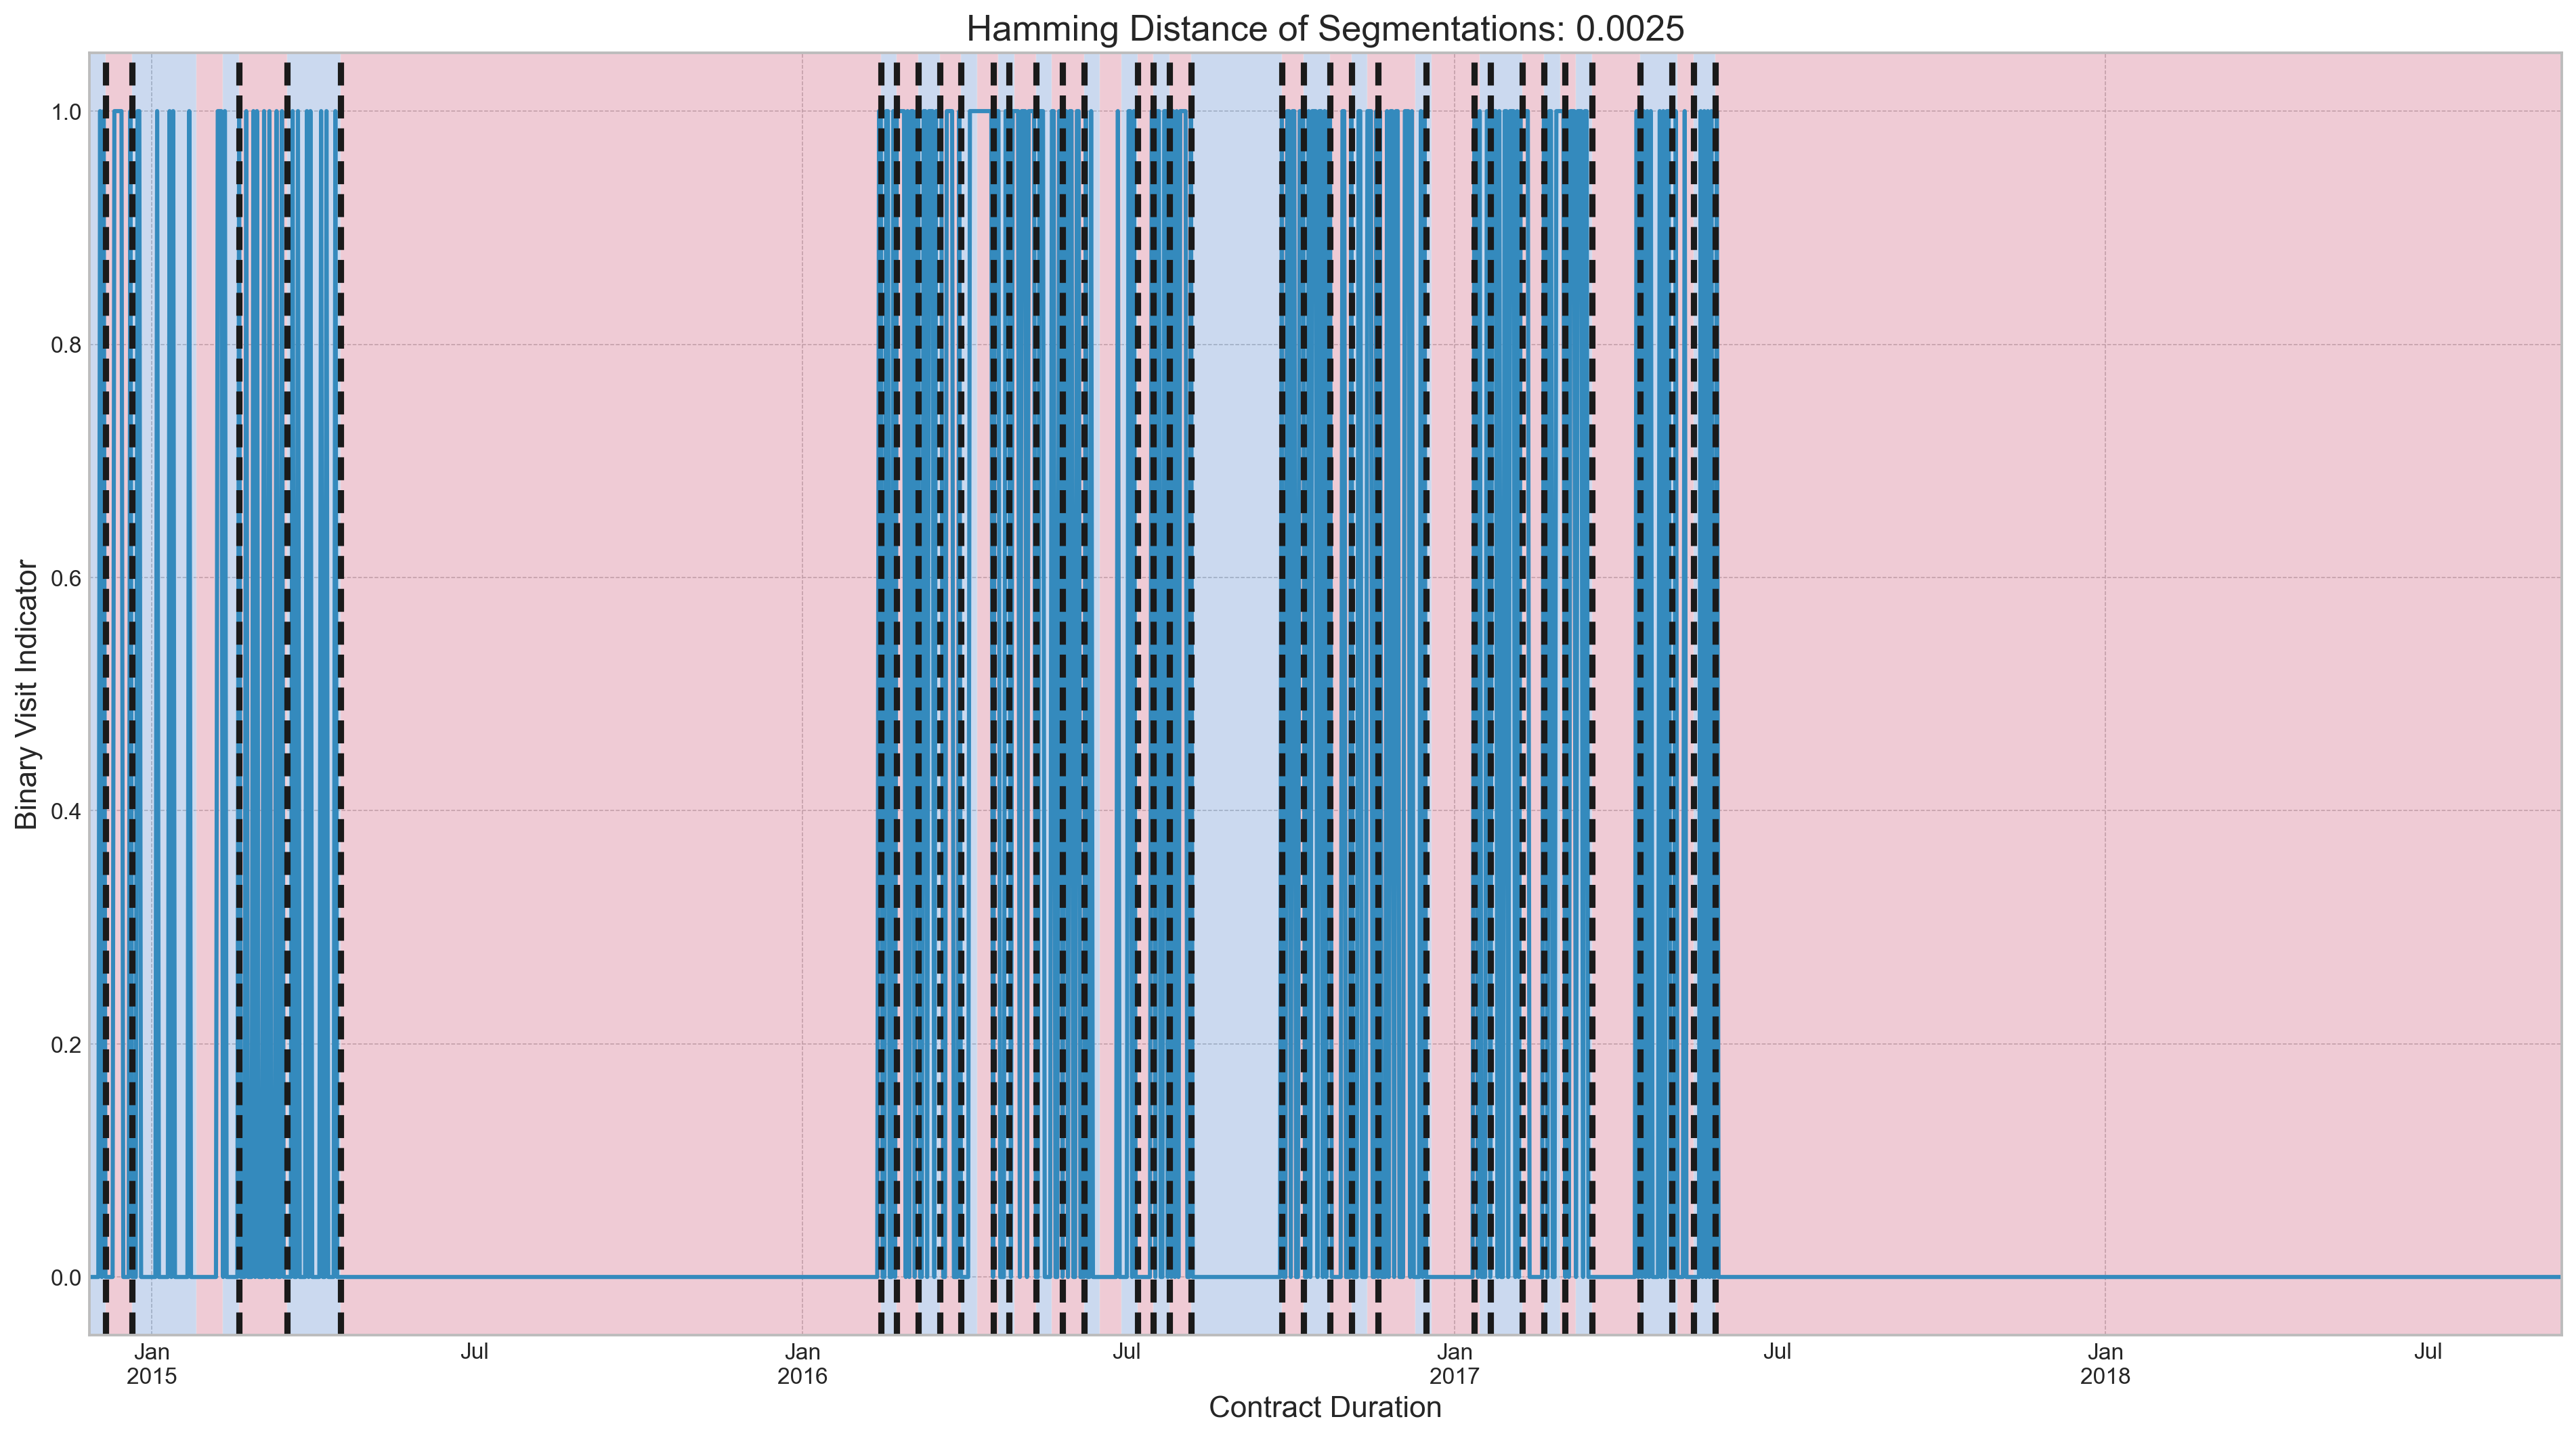

In [44]:
start = time.time()
tsplot_cpd(sample_code, cp_result, login_data, model="ar", jump=3, min_size=7, ic="bic")
end = time.time()
print(end-start)

In [23]:
customer_logins = login_data[login_data["CUST_CODE"] == sample_code].sort_values(by="DATE_SAVED")
customer = cp_result.loc[sample_code]
bin_series = construct_binary_visit_series(customer, customer_logins, login_data["DATE_SAVED"].max())

count    25.000000
mean      5.439846
std       4.305145
min       0.937199
25%       2.812072
50%       3.684664
75%       7.023727
max      16.896852
dtype: float64

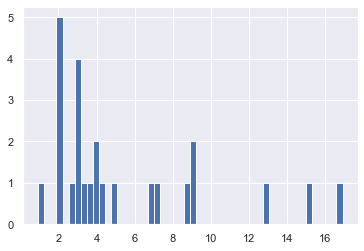

In [204]:
tds = get_timedeltas(customer_logins.DATE_SAVED)
tds.hist(bins="fd")
tds.describe()

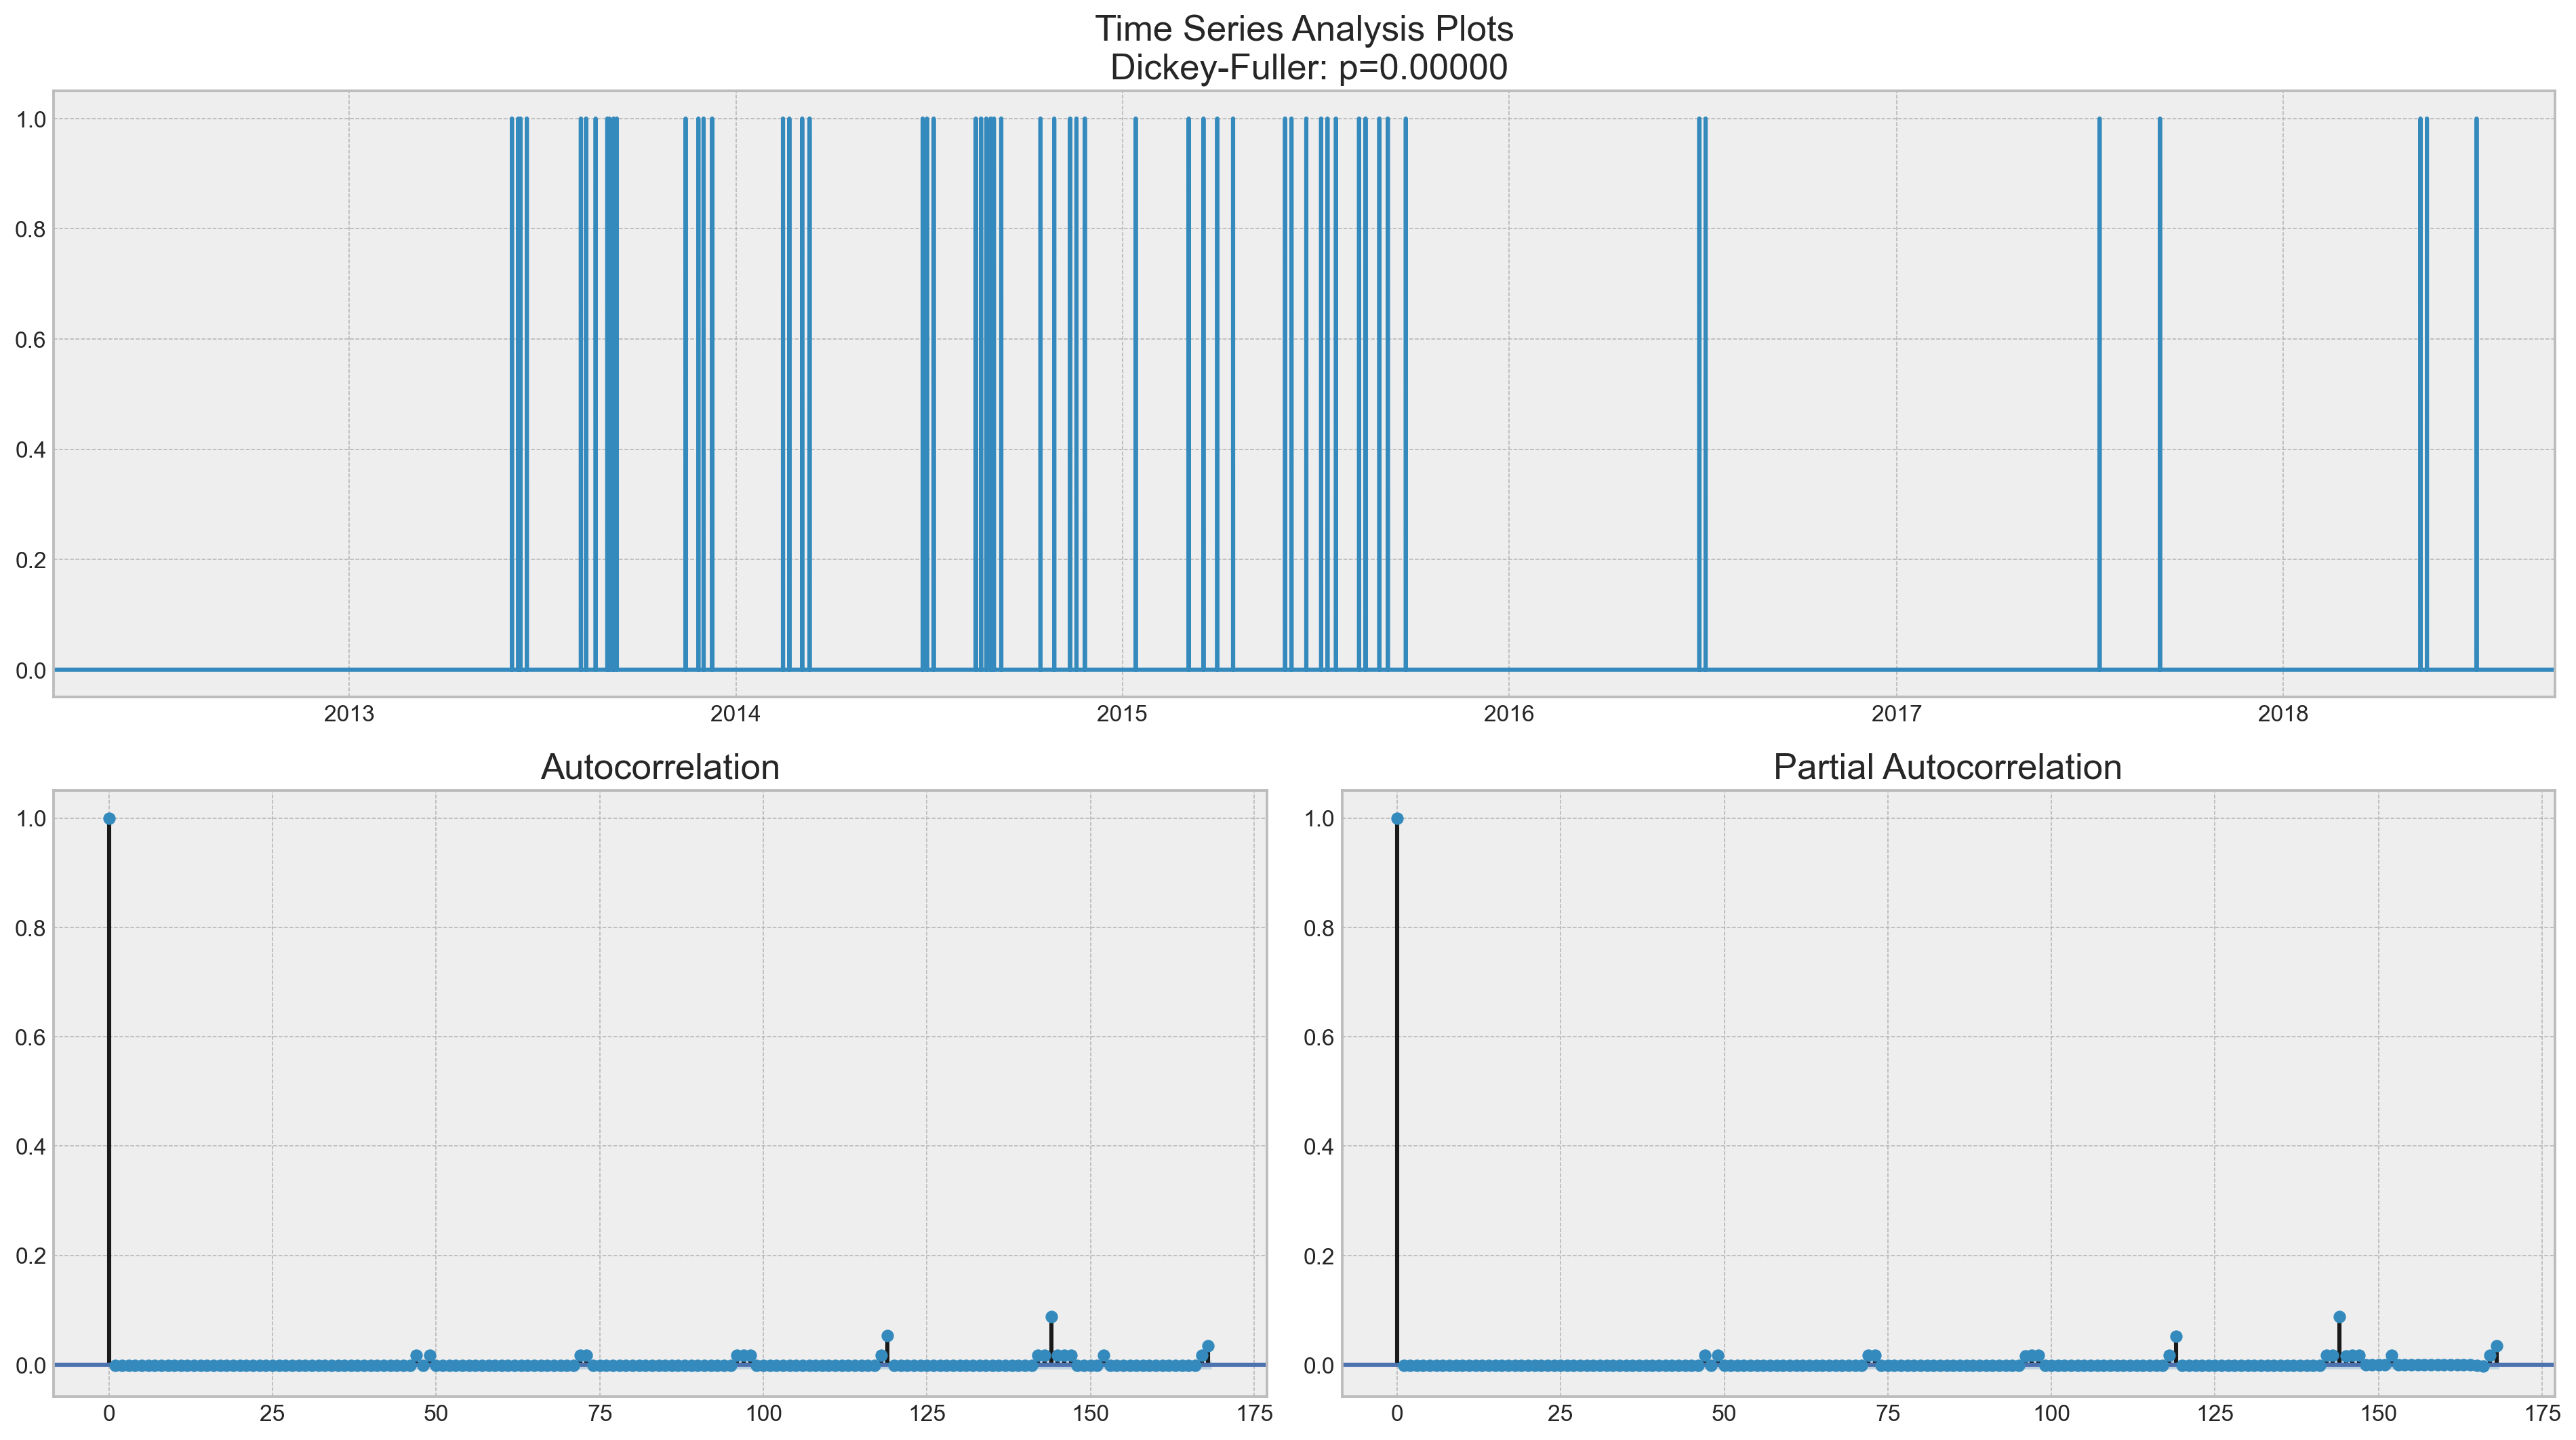

In [206]:
from utils.plot_utils import tsplot

tsplot(bin_series2, lags=7*24)

# Interesting customers 

41694.27 , 8658.10 - good example of Gaussian Mixture Model for timedelta

2100594.28 - multiple strong Dirac comb structures with frequency 1

8124.10 - strong Dirac comb with frequency 1

In [24]:
aic = bin_series.var()
bic = bin_series.var() * np.log(len(bin_series.index))
hqc = 2 * bin_series.var() * np.log(np.log(len(bin_series.index)))
print(aic)
print(bic)
print(hqc)

0.13396680580690604
0.9693327843640216
0.5302448861672215


Elapsed time with jump = 2: 1.491044044494629
[140, 442, 486, 494, 506, 556, 596, 616, 668, 750, 776, 808, 816, 842, 868, 914, 1388]
Number of changepoints found: 17


(<Figure size 720x144 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x17a8fa1d0>])

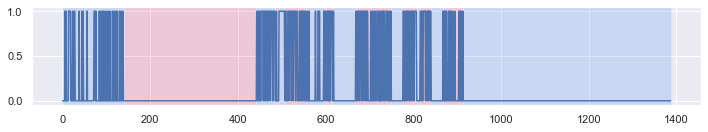

In [56]:
import ruptures as rpt
import time

# detection
jump = 2
min_size = 7
algo = rpt.Pelt(model="l2", jump=jump, min_size=min_size).fit(bin_series.values)

start = time.time()
result = algo.predict(pen=bic)
end = time.time()
print("Elapsed time with jump = {:d}: {}".format(jump, end - start))
print(result)
print("Number of changepoints found: {:d}".format(len(result)))
# display
rpt.display(bin_series, result)

Elapsed time with jump = 1: 5.761013746261597
[139, 443, 485, 494, 507, 556, 596, 619, 669, 750, 777, 808, 816, 841, 868, 914, 1388]
Number of changepoints found: 17


(<Figure size 720x144 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1929ba310>])

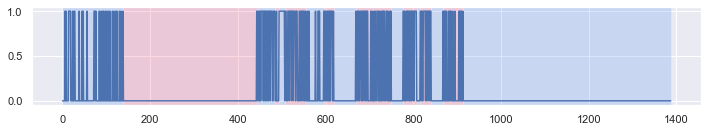

In [55]:
import ruptures as rpt
import time

# detection
jump = 1
min_size = 7
algo = rpt.Pelt(model="l2", jump=jump, min_size=min_size).fit(bin_series.values)

start = time.time()
result = algo.predict(pen=bic)
end = time.time()
print("Elapsed time with jump = {:d}: {}".format(jump, end - start))
print(result)
print("Number of changepoints found: {:d}".format(len(result)))
# display
rpt.display(bin_series, result)

Elapsed time with jump = 1: 11.755807876586914
[84, 142, 453, 485, 494, 531, 560, 596, 606, 618, 679, 698, 730, 742, 777, 804, 816, 841, 1388]
Number of changepoints found: 19


(<Figure size 720x144 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x18ff6ce50>])

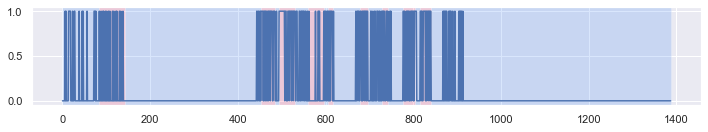

In [52]:
import ruptures as rpt
import time

# detection
jump = 1
min_size = 7
algo = rpt.Pelt(model="ar", jump=jump, min_size=min_size).fit(bin_series.values)

start = time.time()
result = algo.predict(pen=2*bic)
end = time.time()
print("Elapsed time with jump = {:d}: {}".format(jump, end - start))
print(result)
print("Number of changepoints found: {:d}".format(len(result)))
# display
rpt.display(bin_series, result)

In [47]:
# detection

pens = np.linspace(0,3,20)
print(pens)
algo = rpt.Pelt(model="ar").fit(bin_series.values)
result = np.array([len(algo.predict(pen=pen)) for pen in pens])

cpts = pd.Series(result, index=pens)
# display
#rpt.display(bin_series, result)

[0.         0.15789474 0.31578947 0.47368421 0.63157895 0.78947368
 0.94736842 1.10526316 1.26315789 1.42105263 1.57894737 1.73684211
 1.89473684 2.05263158 2.21052632 2.36842105 2.52631579 2.68421053
 2.84210526 3.        ]


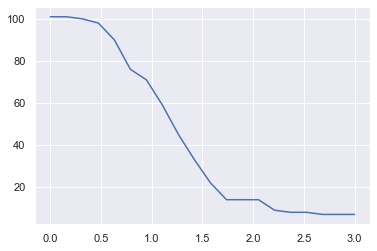

In [48]:
cpts.plot()

0.000000      NaN
0.157895   -136.0
0.315789    -41.0
0.473684    -15.0
0.631579    -15.0
0.789474     -3.0
0.947368     -3.0
1.105263     -2.0
1.263158     -3.0
1.421053     -2.0
1.578947      0.0
1.736842      0.0
1.894737      0.0
2.052632      0.0
2.210526      0.0
2.368421      0.0
2.526316      0.0
2.684211      0.0
2.842105     -2.0
3.000000      0.0
dtype: float64


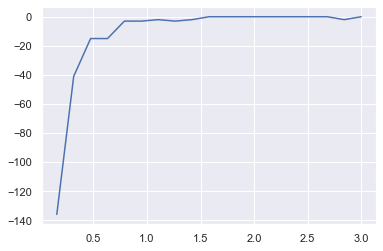

In [236]:
print(cpts.diff())

cpts.diff().plot()

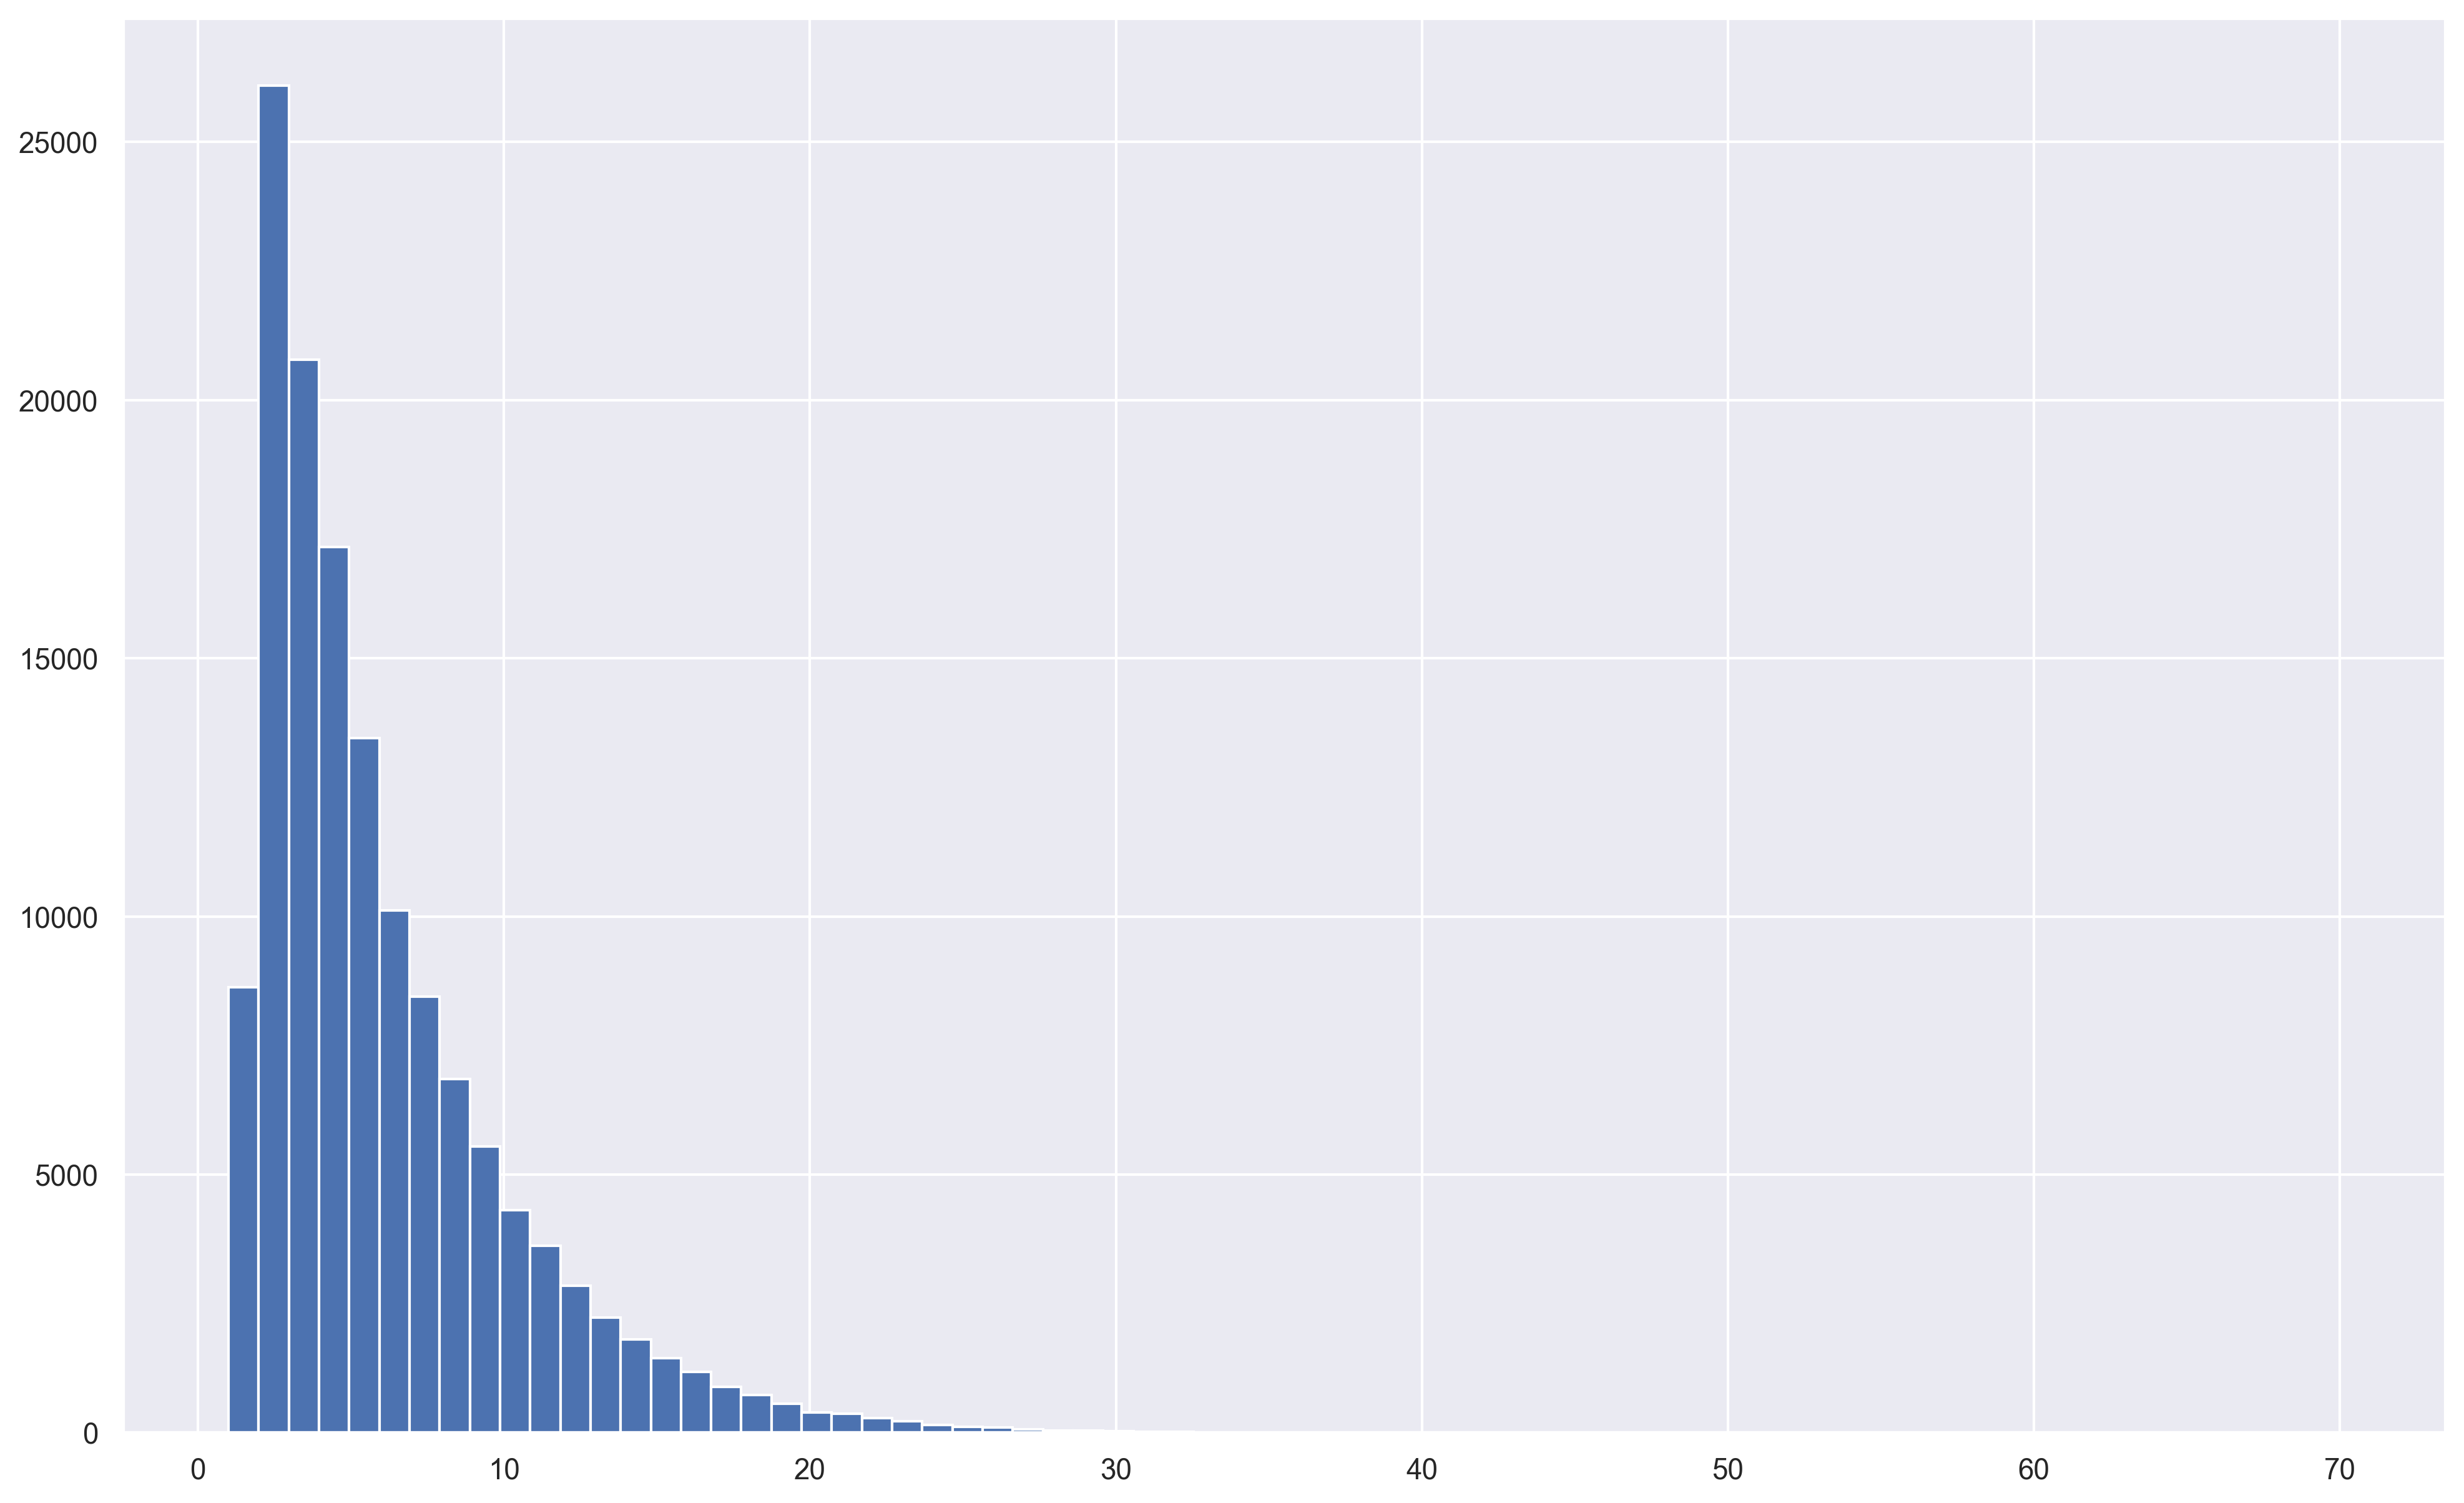

In [86]:
fig, ax = plt.subplots(figsize=(16,10), dpi=300)
changepoint_stats["PELT_bic"].hist(bins=70, ax=ax)
fig.savefig("../plots/result_plots/cps_hist.pdf", format='pdf', bbox_inches='tight')

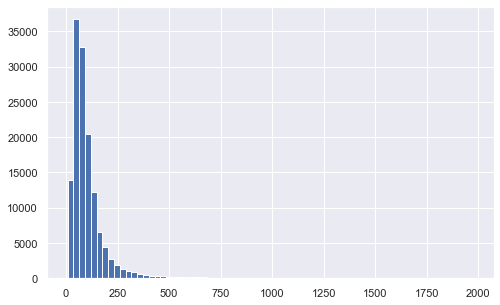

In [30]:
changepoint_features["cp_dt_mean"].hist(bins=70, figsize=(8,5))

In [61]:
changepoint_features[changepoint_features["start_of_year_cps"] > 0]

,PELT_bic,start_of_year_cps,cps_jan,cps_feb,cps_mar,cps_apr,cps_may,cps_jun,cps_jul,cps_aug,cps_sep,cps_oct,cps_nov,cps_dec,cp_dt_mean,cp_dt_median,cp_dt_min,cp_dt_max
CUST_CODE,,,,,,,,,,,,,,,,,,
10000.10,18.0,1.0,1.0,1.0,0.0,4.0,1.0,3.0,2.0,2.0,2.0,0.0,2.0,0.0,64.647059,36.0,6.0,274.0
10000016.9,12.0,1.0,1.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,111.545455,40.0,8.0,433.0
10000024.9,21.0,1.0,2.0,1.0,3.0,0.0,2.0,2.0,3.0,4.0,1.0,2.0,0.0,1.0,107.500000,40.5,6.0,1309.0
10000027.9,16.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,4.0,3.0,1.0,0.0,143.333333,68.0,24.0,681.0
10000030.9,26.0,1.0,4.0,2.0,4.0,5.0,2.0,0.0,0.0,0.0,1.0,4.0,3.0,1.0,86.000000,16.0,6.0,863.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92524.12,7.0,1.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,42.166667,17.0,5.0,128.0
92525.12,7.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,42.166667,15.0,7.0,180.0
92533.12,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,126.500000,126.5,7.0,246.0


In [62]:
#fraction of users having a changepoint in the first five days of a year
16917 / 138563

0.12208886932297944

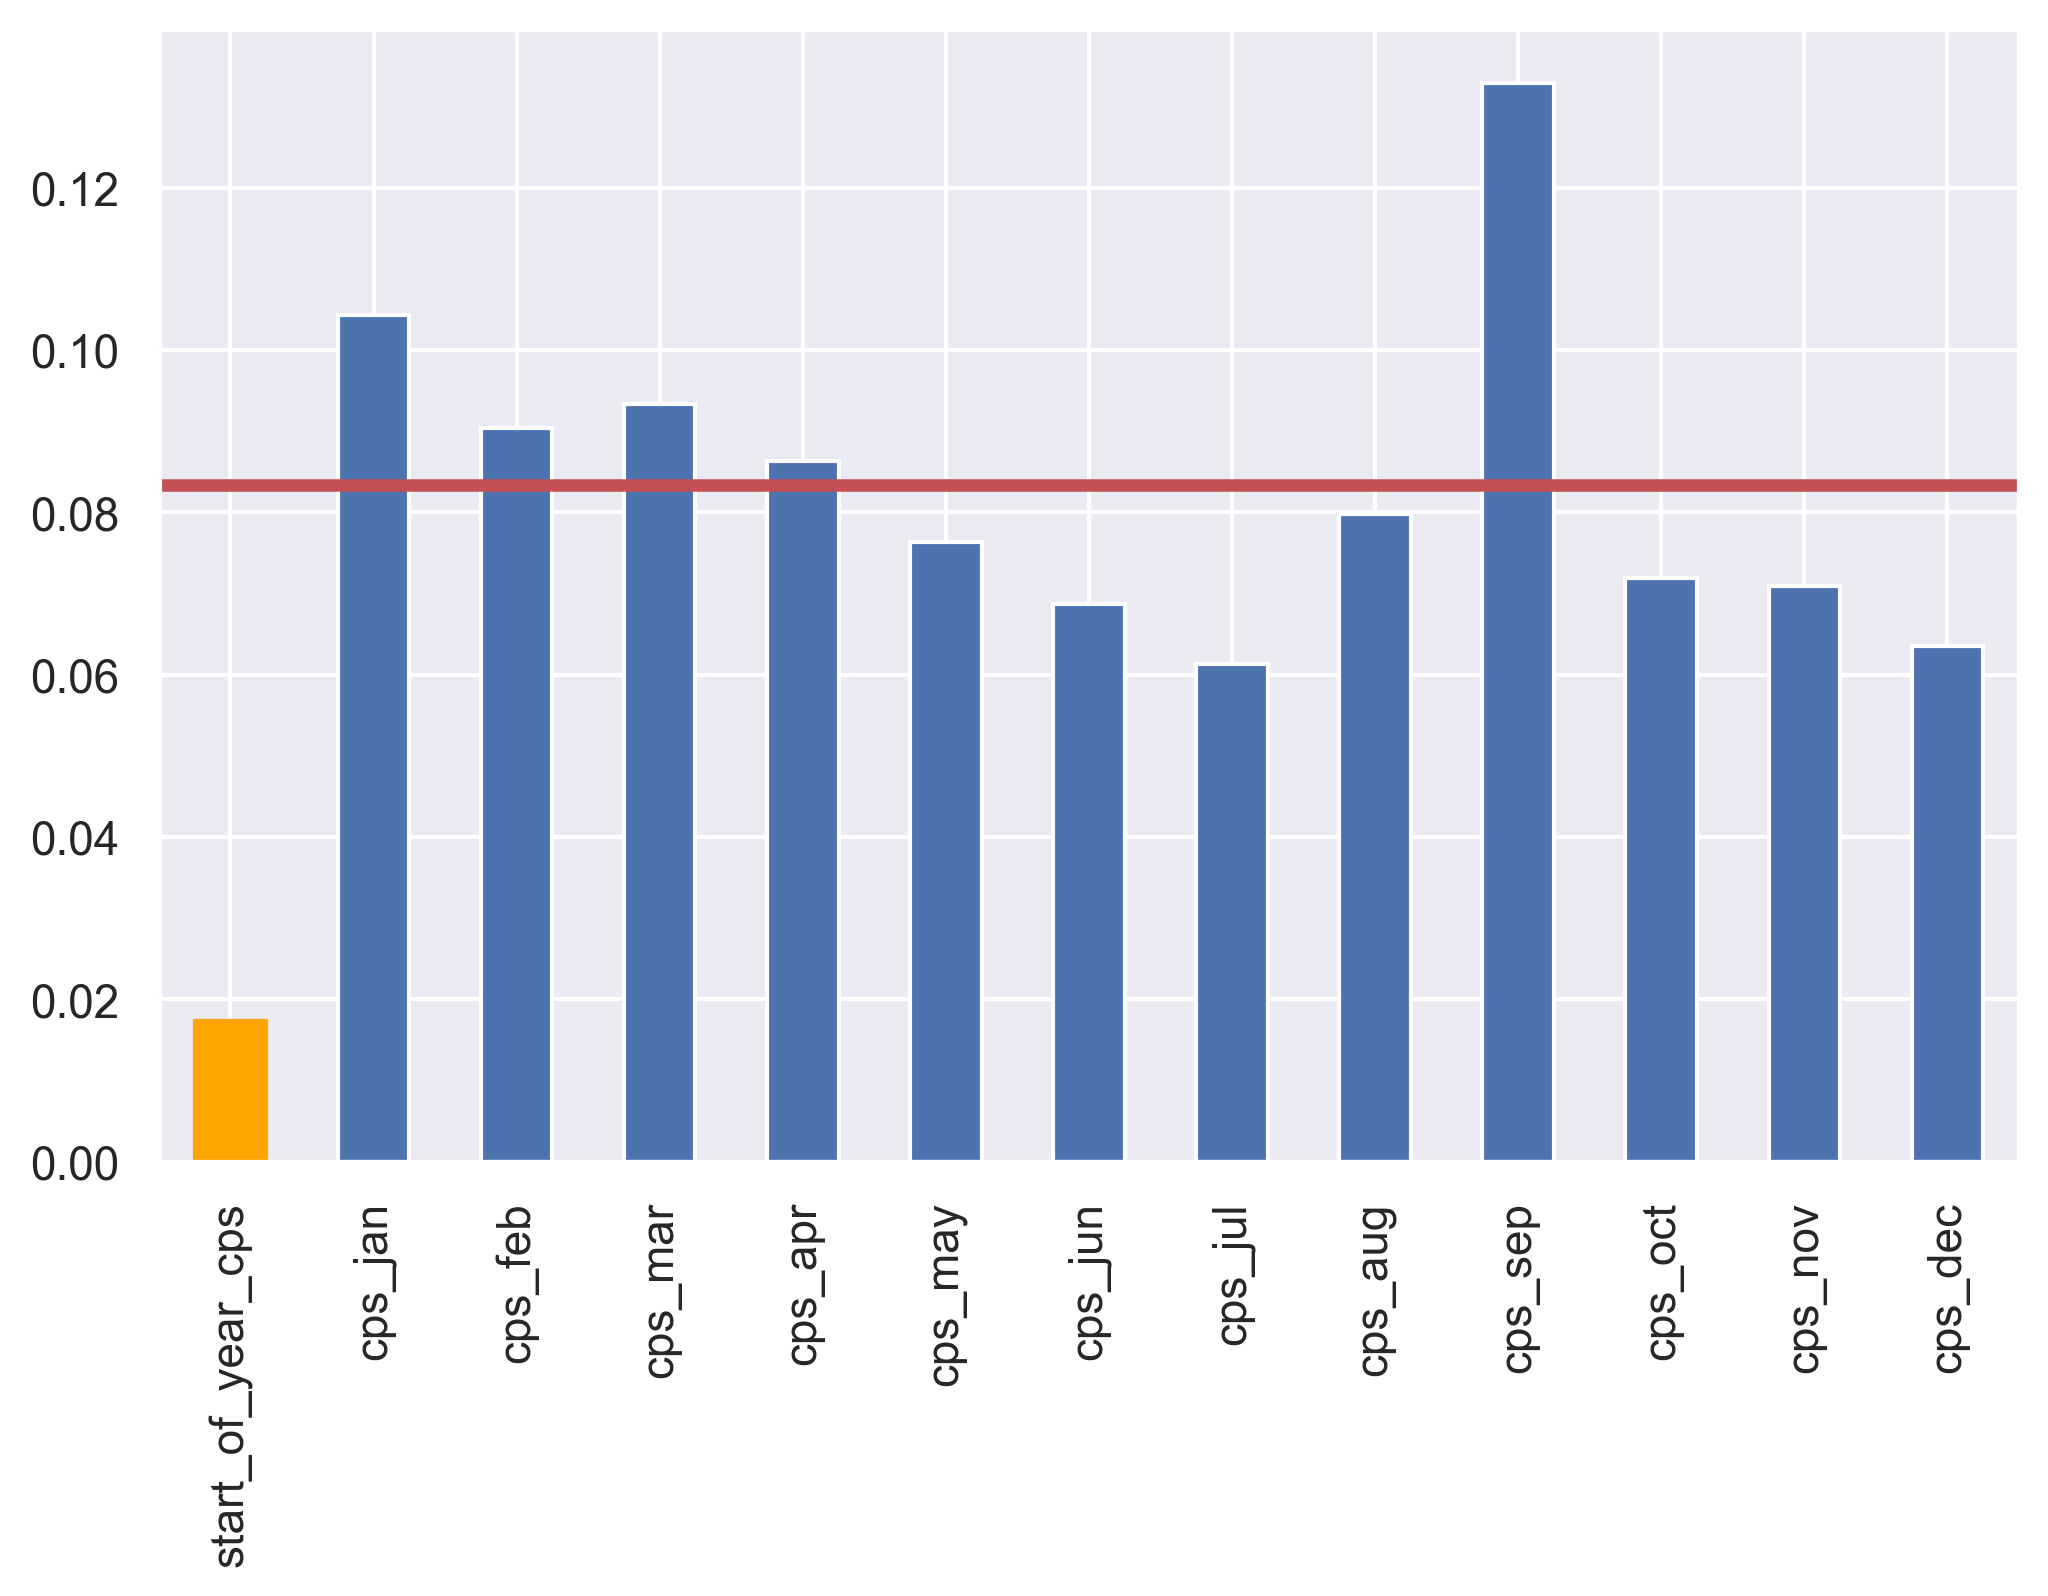

In [148]:
a = changepoint_features.sum() 

a /= a.iloc[0]

fig, ax = plt.subplots(figsize=(8,5), dpi=300)

a.iloc[1:14].plot(kind="bar", ax=ax)

ax.get_children()[0].set_color("orange")

ax.axhline(y=1/12, c="r", lw=3)

fig.savefig("../plots/result_plots/cps_by_month.pdf", format='pdf', bbox_inches='tight')

In [88]:
a

PELT_bic              1.000000
start_of_year_cps     0.017322
cps_jan               0.104274
cps_feb               0.090383
cps_mar               0.093396
cps_apr               0.086371
cps_may               0.076364
cps_jun               0.068673
cps_jul               0.061258
cps_aug               0.079843
cps_sep               0.132895
cps_oct               0.071973
cps_nov               0.070975
cps_dec               0.063595
cp_dt_mean           13.982953
cp_dt_median          8.800783
cp_dt_min             3.519869
cp_dt_max            45.909119
dtype: float64

In [89]:
#percentage of january changepoints that are "start of year" changepoints
a.iloc[1] / a.iloc[2]

0.16611532723616787

In [144]:
a.loc["cps_sep"] / (1/12)

1.5947375438908395

In [90]:
#percentage of start of year changepoints to normally expected changepoints
a.iloc[1] / (5/365)

1.2644726239040576

In [123]:
def set_size(width, fraction=1):
    """ Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


In [124]:
set_size(345)

(4.77376504773765, 2.9503490538081323)